In [12]:
%matplotlib inline
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import plotly
from plotly.graph_objs import Scatter, Layout
import time
import imageio

In [13]:
WORKING_DIR = '.' #os.path.dirname(__file__)

DATA_DIR = os.path.join(WORKING_DIR, 'data')
OUTPUT_FILE = os.path.join(WORKING_DIR, 'motionVectors.csv')

In [14]:
input_imgs = [cv2.imread(os.path.join(DATA_DIR, name), 0) for name in os.listdir(DATA_DIR)]

In [15]:
def show_img(img):
    plt.axis('off')
    plt.imshow(img, cmap = 'gray')

In [32]:
class MotionTracker:
    
    def __init__(self, frames, before_gif, after_gif):
        self.frames = frames
        self.motion_vectors = []
        self.relative_motion_vectors = []
        self.frame_processing_time = []
        self.calculate_vectors()
        self.shifted_frames = []
        self.shift_frames()
        self.save_imgs_in_gif(before_gif, frames)
        self.save_imgs_in_gif(after_gif, self.shifted_frames)
    
    def calculate_vectors(self):
        global_shift = np.array([.0, .0])
        start_time = time.time()
        for i in range(len(self.frames)-1):
            self.relative_motion_vectors.append(self.get_relative_vec(self.frames[i], self.frames[i+1]))
            global_shift += self.relative_motion_vectors[-1]
            self.motion_vectors.append(np.copy(global_shift))
            self.frame_processing_time.append(time.time() - start_time)
    
    @staticmethod
    def get_relative_vec(img1, img2):
        # Find the keypoints and descriptors with ORB
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(img1, None)
        kp2, des2 = orb.detectAndCompute(img2, None)
        # Match descriptors.
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1,des2)
        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

        diff_pts = dst_pts - src_pts

        return np.mean(diff_pts[:10,0]), np.mean(diff_pts[:10,1])
    
    def plot_time(self):
        x_frames = [i for i in range(len(self.frames)-1)]
        plt.plot(x_frames, self.frame_processing_time)
        plt.ylabel('time, seconds')
        plt.xlabel('frame')
        plt.show()
        
    def dumpVectors(self, filename):
        with open(filename, mode='w', encoding='utf8', newline='') as f_dump:
            writer = csv.writer(f_dump, delimiter='\t')
            writer.writerows(self.motion_vectors)
    
    @staticmethod
    def shift_frame(frame, vec):
        M = np.float32([[1,0,-vec[0]],[0,1,-vec[1]]])
        dst = cv2.warpAffine(frame, M, frame.shape[::-1])
        return dst
        
    def shift_frames(self):
        self.shifted_frames.append(self.frames[0])
        for i in range(len(self.motion_vectors)):
            self.shifted_frames.append(self.shift_frame(self.frames[i], self.motion_vectors[i]))
         
    @staticmethod
    def save_imgs_in_gif(filename, images):
        with imageio.get_writer(os.path.join(WORKING_DIR, filename), mode='I') as writer:
            for img in images:
                writer.append_data(img)
        

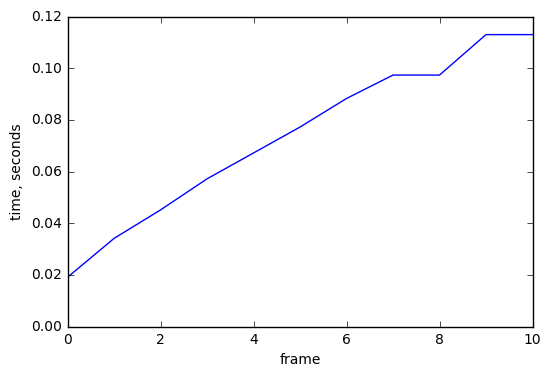

In [33]:
motion_tracker = MotionTracker(input_imgs, 'before.gif', 'after.gif')
motion_tracker.dumpVectors(OUTPUT_FILE)
motion_tracker.plot_time()

<table>
  <tr>
    <th style="text-align:center">Before</th>
    <th style="text-align:center">After</th>
  </tr>
  <tr>
    <td><img src="before.gif"></td>
    <td><img src="after.gif"></td>
  </tr>
</table>